# Find IT UGM - ODE 

## Import Library

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

np.random.seed(5)
%matplotlib inline

In [55]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Custom Classes / Function

In [56]:
from model import RandomForest

## Data Preparation + Cleansing

### Features

`h1n1_concern` - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

`h1n1_knowledge` - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

`behavioral_antiviral_meds` - Has taken antiviral medications. (binary)

`behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)

`behavioral_face_mask` - Has bought a face mask. (binary)

`behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)

`behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)

`behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)

`behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)

`doctor_recc_h1n1` - H1N1 flu vaccine was recommended by doctor. (binary)

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

`child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)

`health_worker` - Is a healthcare worker. (binary)

`health_insurance` - Has health insurance. (binary)

`opinion_h1n1_vacc_effective` - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_h1n1_risk` - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_h1n1_sick_from_vacc` - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`age_group` - Age group of respondent.

`education` - Self-reported education level.

`race` - Race of respondent.

`sex` - Sex of respondent.

`income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.

`marital_status` - Marital status of respondent.

`rent_or_own` - Housing situation of respondent.

`employment_status` - Employment status of respondent.

`hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

`census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

`household_adults` - Number of other adults in household, top-coded to 3.

`household_children` - Number of children in household, top-coded to 3.

`employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.

`employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.

### Target variables :
`h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.

`seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes.

### Loading Data

In [57]:
df_features = pd.read_csv('data/training_set_features.csv')
df_labels = pd.read_csv('data/training_set_labels.csv')

df_test_features = pd.read_csv('data/test_set_features.csv')

In [58]:
df_labels.columns

Index(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [59]:
df_features.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [60]:
df_test_features.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

### Handling null data

In [61]:
df_features.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

Features with null data: 

`h1n1_concern`                      92 - (0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.)

`h1n1_knowledge`                   116 - (0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.)

`behavioral_antiviral_meds`         71 - (binary)

`behavioral_avoidance`             208 - (binary)

`behavioral_face_mask`              19 - (binary)

`behavioral_wash_hands`             42 - (binary)

`behavioral_large_gatherings`       87 - (binary)

`behavioral_outside_home`           82 - (binary)

`behavioral_touch_face`            128 - (binary)

`doctor_recc_h1n1`                2160 - (binary)

`doctor_recc_seasonal`            2160 - (binary)

`chronic_med_condition`            971 - (binary)

`child_under_6_months`             820 - (binary)

`health_worker`                    804 - (binary)

`health_insurance`               12274 - (binary)

`opinion_h1n1_vacc_effective`      391 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_h1n1_risk`                388 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_h1n1_sick_from_vacc`      395 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`opinion_seas_vacc_effective`      462 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_seas_risk`                514 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_seas_sick_from_vacc`      537 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`education`                       1407 - ('< 12 Years', '12 Years', 'College Graduate', 'Some College')

`income_poverty`                  4423 - ('Below Poverty', '<= $75,000, Above Poverty', '> $75,000')

`marital_status`                  1408 - ('Not Married', 'Married')

`rent_or_own`                     2042 - ('own', 'rent')

`employment_status`               1463 - ('Not in Labor Force', 'Employed', 'Unemployed')

`household_adults`                 249 - (0, 1, 2, 3)

`household_children`               249 - (0, 1, 2, 3)

`employment_industry`            13330 - ('pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh','ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf','arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax','dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo', 'qnlwzans')

`employment_occupation`          13470 - ('xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp', 'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi', 'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss', 'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew', 'uqqtjvyb', 'pvmttkik', 'dcjcmpih')

In [62]:
df_test_features.isna().sum()

respondent_id                      0
h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
m

In [63]:
df_labels.isna().sum()

respondent_id       0
h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

df_labels doesn't contain any null data, so null data cleaning will be done to df_features only

In [64]:
df_features["employment_occupation"].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [65]:
df_features = pd.read_csv("data/training_set_features.csv")
df_test_features = pd.read_csv("data/test_set_features.csv")

#### Education columns

With the assumption that education is affected by sex and age group, education will be filled using RF on sex and age group columns

##### Train Data

In [66]:
age_group = pd.get_dummies(df_features["age_group"], prefix="age")
sex = pd.get_dummies(df_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_features = df_features.fillna(education_predict[["education"]])

##### Test Data

In [67]:
age_group = pd.get_dummies(df_test_features["age_group"], prefix="age")
sex = pd.get_dummies(df_test_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_test_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_test_features = df_test_features.fillna(education_predict[["education"]])

#### Employment Occupation and Industry Columns

In [68]:
df_features[["employment_occupation", "employment_industry", "employment_status"]].loc[(df_features["employment_status"] == "Unemployed") | (df_features["employment_status"] == "Not in Labor Force")].count()

employment_occupation        0
employment_industry          0
employment_status        11684
dtype: int64

NaN happened because the respondent is "Unemployed" or "Not in Labor" because of that, we can fill the NaN value with some specific value, such as "xxxxx"

In [69]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

#### Employment Status Columns

In [70]:
df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

employment_occupation    1463
employment_industry      1463
employment_status           0
dtype: int64

Because of above details, employment_status with NaN data will be filled with "Unemployed'

In [71]:
df_features[["employment_status"]] = df_features[["employment_status"]].fillna("xxxxx")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("xxxxx")

#### Other Columns

other features will be filled with the largest data / mode

In [72]:
df_features.fillna(df_features.mode().iloc[0], inplace=True)
df_test_features.fillna(df_test_features.mode().iloc[0], inplace=True)

<AxesSubplot:>

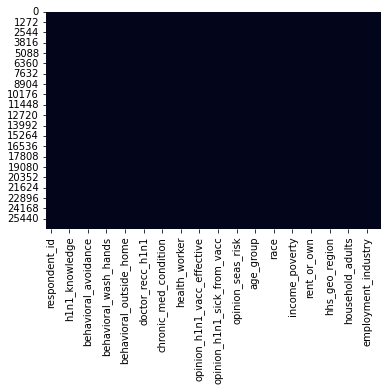

In [74]:
sns.heatmap(df_features.isnull(), cbar=False)

<AxesSubplot:>

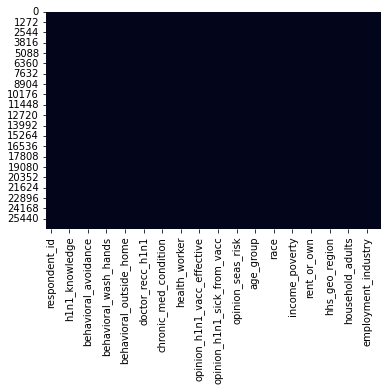

In [75]:
sns.heatmap(df_test_features.isnull(), cbar=False)

## EDA

## Modelling